# Plot trends in AIRS spectral OLR by month

In [1]:
import sys
# Add common resources folder to path
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/')
sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/Common/') # is this good or not good. I should reorg.
# sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    ccrs, metrics, Iterable, cmaps,
    glob
    )

from functions import (
    masked_average, add_weights, sp_map,
    season_mean, get_dpm, leap_year, regress_1d,
    to_png, polarCentral_set_latlim, add_map_features,
    plot_trends
    )

from collections import deque
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
os.getcwd()

'/glade/u/home/jonahshaw/Scripts/git_repos/spectral_ice/gridded_trends'

In [3]:
os.listdir('/glade/u/home/jonahshaw/rsyncd/')

['CAM6Paleo_COSPeval.zip']

## Load AIRS data

Nearly 20 years of monthly files, so I will work with a single file first.

In [2]:
airs_dir = '/glade/work/jonahshaw/obs/AIRS/'
# airs_files = glob.glob('%s/L3OLR/**.nc' % airs_dir)
airs_files = glob.glob('%s/proc/**.nc' % airs_dir)

airs_files.sort()
# ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'

In [34]:
airs_files

['/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20020901.M01.L3_SpecOLR.std.v06_01_00.M.191116170609.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021001.M01.L3_SpecOLR.std.v06_01_00.M.191116170632.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021101.M01.L3_SpecOLR.std.v06_01_00.M.191116170649.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20021201.M01.L3_SpecOLR.std.v06_01_00.M.191116170708.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030101.M01.L3_SpecOLR.std.v06_01_00.M.191116171332.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030201.M01.L3_SpecOLR.std.v06_01_00.M.191116171348.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030301.M01.L3_SpecOLR.std.v06_01_00.M.191116171405.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030401.M01.L3_SpecOLR.std.v06_01_00.M.191116171421.nc',
 '/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20030501.M01.L3_SpecOLR.std.v06_01_00.M.1911161714

### The single file seems to work appropriately

In [3]:
test_airs = xr.open_dataset(airs_files[0])

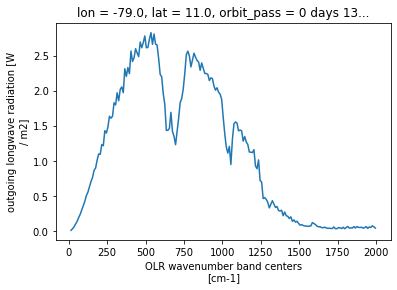

In [4]:
test_airs['olr_spectral'][0,0,:,50,50].plot()

### Create new files with time dimension so that concatenation is possible. Done with and commented.

In [7]:
def add_time_coord(da):
    
    # add appropriate time coordinate from existing coordinate:
    da = da.assign_coords({'time':da['obs_time_tai93'][0].values}).expand_dims('time')
    
    return da

In [10]:
# for i,file_name in enumerate(airs_files):
#     _da = xr.open_dataset(file_name)
    
#     timed = add_time_coord(_da)
#     timed.to_netcdf('%s/proc/%s' % (airs_dir,file_name.split('/')[-1]))
    
#     timed.close()
#     _da.close()
    
#     if i > 10:
#         break

## Open all AIRS files together

In [134]:
# Remove the bad file (masking was being difficult)

# airs_files.pop(69)

'/glade/work/jonahshaw/obs/AIRS//proc/AIRS.AQUA.AIRS.20080601.M01.L3_SpecOLR.std.v06_01_00.M.191116173031.nc'

In [3]:
# all_airs.close()
# all_airs = xr.open_mfdataset(airs_files)
all_airs = xr.open_mfdataset(airs_files,
                             parallel=True)

### Subset Arctic spectraol olr data and average over orbits to munge

In [6]:
all_airs_arc = all_airs.sel(lat=slice(60,None))

In [14]:
all_airs_arc_vars = all_airs_arc[['olr_spectral','olr_clr_spectral']]

In [15]:
all_airs_arc_vars_norbit = all_airs_arc_vars.mean(dim='orbit_pass')

In [16]:
all_airs_arc_vars_norbit

,Array,Chunk
Bytes,434.14 MB,2.15 MB
Shape,"(202, 199, 15, 180)","(1, 199, 15, 180)"
Count,1212 Tasks,202 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,434.14 MB,2.15 MB
Shape,"(202, 199, 15, 180)","(1, 199, 15, 180)"
Count,1212 Tasks,202 Chunks
Type,float32,numpy.ndarray


Save the subset/processed files. Will require running all the delay operations and writing ~1gB to memory.

In [17]:
all_airs_arc_vars_norbit['olr_spectral'].to_netcdf('%s/arc_proc/%s' % (airs_dir,'olrspectral_arcticsubset_orbavg.nc')) # these are "large" ~400mb files

all_airs_arc_vars_norbit['olr_clr_spectral'].to_netcdf('%s/arc_proc/%s' % (airs_dir,'olrclrspectral_arcticsubset_orbavg.nc')) # these are "large" ~400mb files

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


#### Sanity check indicates something wrong in 2008-06 (corrected by removing the bad file or just looking at the Arctic)

It just appears in a single orbit cycle, for two pixels (I think)

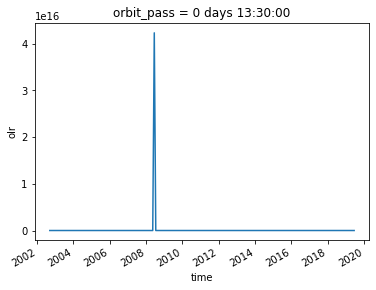

In [6]:
all_airs['olr'][:,0,:,:].mean(dim=['lat','lon']).plot()

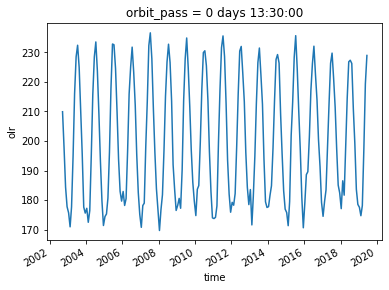

In [7]:
all_airs['olr'][:,0,:,:].sel(lat=slice(70,90)).mean(dim=['lat','lon']).plot()

It appears to be a single pixel, so it should be easy to mask it if I ever want to.

#### Mask bad data in a single file:

In [8]:
bad_file = airs_files[69]
bad_ds = xr.open_dataset(bad_file)

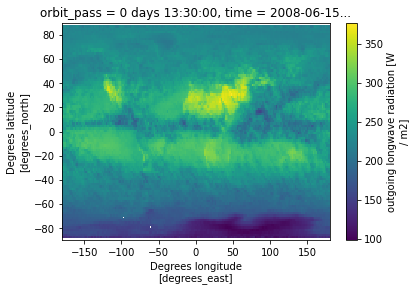

In [9]:
bad_ds['olr'][0,0].where(bad_ds['olr'][0,0] < 1e3,np.nan).plot()

In [10]:
just_bad = bad_ds['olr'][0,0].where(bad_ds['olr'][0,0] > 1e3) #.plot()

Track down the indices of the bad data (there must be an analytic way...). Use drop dims.

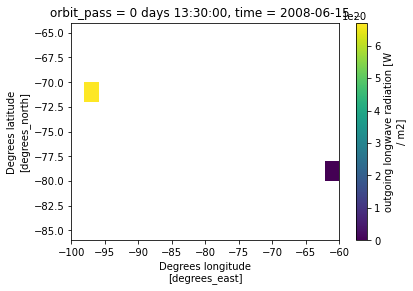

In [11]:
just_bad.sel(lat=slice(-85,-65),lon=slice(-100,-60)).plot()

The bad pixels are located and indices (9,41) and (5,59).

In [12]:
obs_vars = ['olr','olr_clr','olr_spectral','olr_clr_spectral']

#### This doesn't entirely work, but I don't need it for high Arctic calculations.

In [126]:
indx = [[9,41],[5,59]] # indices for values to mask

wasbad_ds = bad_ds.copy()

for i in obs_vars:
    print(i)
    
    # Transpose so I can index correctly
    temp_ds = bad_ds[i].transpose('lat','lon',...)
    
    for j in indx:
        replace = np.nan * np.zeros(temp_ds[j[0],j[1]].shape)
        print(replace.shape)
        temp_ds.load()
        temp_ds[j[0],j[1]] = replace # apply the masked array
    wasbad_ds[i] = temp_ds

olr
(1, 2)
(1, 2)
olr_clr
(1, 2)
(1, 2)
olr_spectral
(1, 2, 199)
(1, 2, 199)
olr_clr_spectral
(1, 2, 199)
(1, 2, 199)


### Plot month OLRs for the Arctic Ocean (70-90N)

If I want to use a better mask, should I use the LANDFRAC variable in CESM or is there something better?

In [13]:
olr_wgt = add_weights(all_airs['olr'])

In [14]:
month_groups = olr_wgt.groupby('time.month')

Compute monthly OLRs (inefficient, could vectorize)

In [15]:
olr_temp = []
labels = []

for label,month in month_groups:
    arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat<70)
    
    olr_temp.append(arc_ocn_avg)
    labels.append(label)
#     break
olr_temp = np.array(olr_temp)

#### Sanity plot looks good

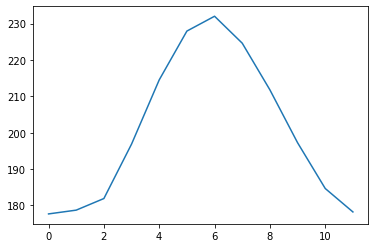

In [16]:
plt.plot(olr_temp)

### Plot a monthly trend

In [27]:
olr_wgt_dechunk = olr_wgt.chunk({'time':-1,'orbit_pass':-1,'lat':-1,'lon':-1})

In [28]:
# average over the Arctic Ocean spatially, but not temporally
spat_avg = masked_average(olr_wgt_dechunk,weights=olr_wgt['cell_weight'],mask=olr_wgt.lat<70,dim=['lat','lon'])

#### All months sanity plot looks good

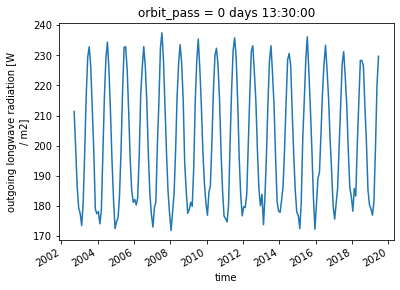

In [30]:
spat_avg[:,0].plot()

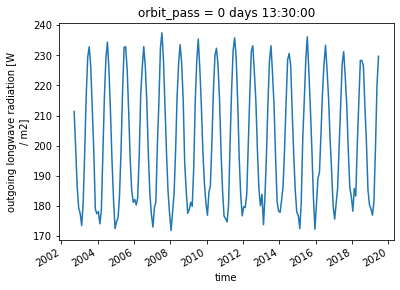

In [30]:
spat_avg[:,1].plot()

In [33]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

KeyboardInterrupt: 

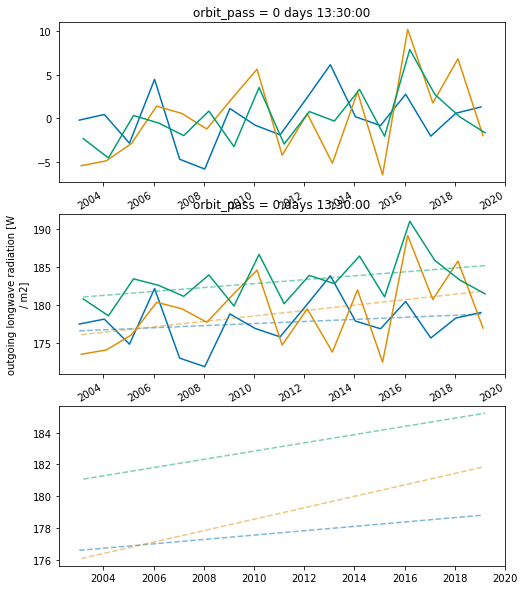

In [34]:
fig,axes = plt.subplots(3,1,figsize=(8,10))


lines=[]
mon_groups = spat_avg[:,0].groupby('time.month') # arbitrary choice of passover time here

for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
    mon_norm = mon - mon.mean() # normalize to the average

    out = regress_1d(mon['time.year'],mon)
    line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
    label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)
    
    
    mon_norm.plot(label=label,ax=axes[0],color=color)
    out = mon.plot(label=label,ax=axes[1],color=color)
    
    axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
    axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)    
    
    lines.append(out)
    
axes[2].legend(loc=[1,1])

fig.suptitle('AIRS OLR (70-90N)',fontsize=24)

[<matplotlib.lines.Line2D object at 0x2ba03235f750>, <matplotlib.lines.Line2D object at 0x2ba030fb95d0>, <matplotlib.lines.Line2D object at 0x2ba030f797d0>, <matplotlib.lines.Line2D object at 0x2ba032285810>, <matplotlib.lines.Line2D object at 0x2ba03255a2d0>, <matplotlib.lines.Line2D object at 0x2ba03182bbd0>, <matplotlib.lines.Line2D object at 0x2ba03242ca50>, <matplotlib.lines.Line2D object at 0x2ba0325d6950>, <matplotlib.lines.Line2D object at 0x2ba030f63b50>, <matplotlib.lines.Line2D object at 0x2ba03265cd50>, <matplotlib.lines.Line2D object at 0x2ba0325e0d90>, <matplotlib.lines.Line2D object at 0x2ba0326783d0>]


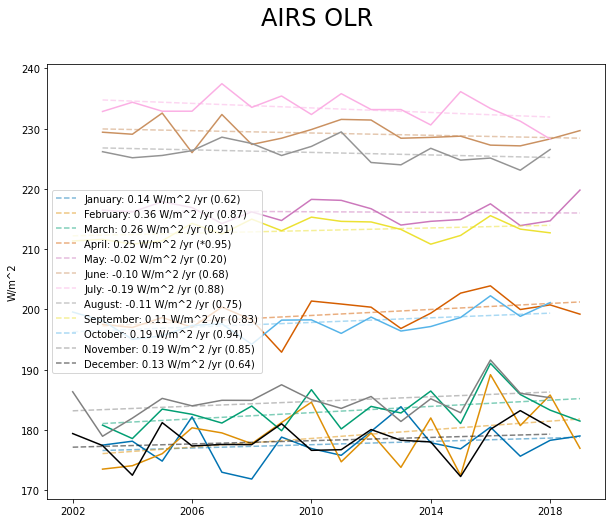

In [18]:
plot_trends(all_airs['olr'][:,0,:,:],'AIRS OLR')

In [6]:
all_airs['olr'][:,0,:,:]

,Array,Chunk
Bytes,13.09 MB,64.80 kB
Shape,"(202, 90, 180)","(1, 90, 180)"
Count,808 Tasks,202 Chunks
Type,float32,numpy.ndarray


## Load CERES data

I am using files from Brian Medeiros (most recent, somehow processed)

In [36]:
ceres_savedir = '/glade/work/jonahshaw/obs/CERES/tseries/'

ceres_path = '/glade/work/brianpm/observations/ceres'
ceres_files = glob.glob('%s/CERES_EBAF_Ed4.1_Subset*.nc' % ceres_path)

In [37]:
# Loaded save timeseries or process them from Brian Medeiros' monthly data
if os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
    ceres_asr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)
    
if os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
    ceres_olr = xr.open_dataset('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)

if (not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir)) or (not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir)):    
    all_ceres = xr.open_mfdataset(ceres_files)
    
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_ASR_200003-202102.nc' % ceres_savedir):
        ceres_asr = all_ceres['solar_mon'] - all_ceres['toa_sw_all_mon']
        
    if not os.path.exists('%s/CERES_EBAF_Ed4.1_OLR_200003-202102.nc' % ceres_savedir):
        ceres_olr = all_ceres['toa_lw_all_mon']

In [39]:
ceres_dir = '/glade/work/jonahshaw/obs/CERES'
# ceres_file = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-202102.nc'
ceres_file = 'CERES_EBAF_Ed4.1_Subset_200003-202102.nc'

ceres_ds = xr.open_dataset('%s/%s' % (ceres_dir,ceres_file))

ceres_ds = ceres_ds.assign_coords(lon=(ceres_ds.lon % 360)).sortby('lon')

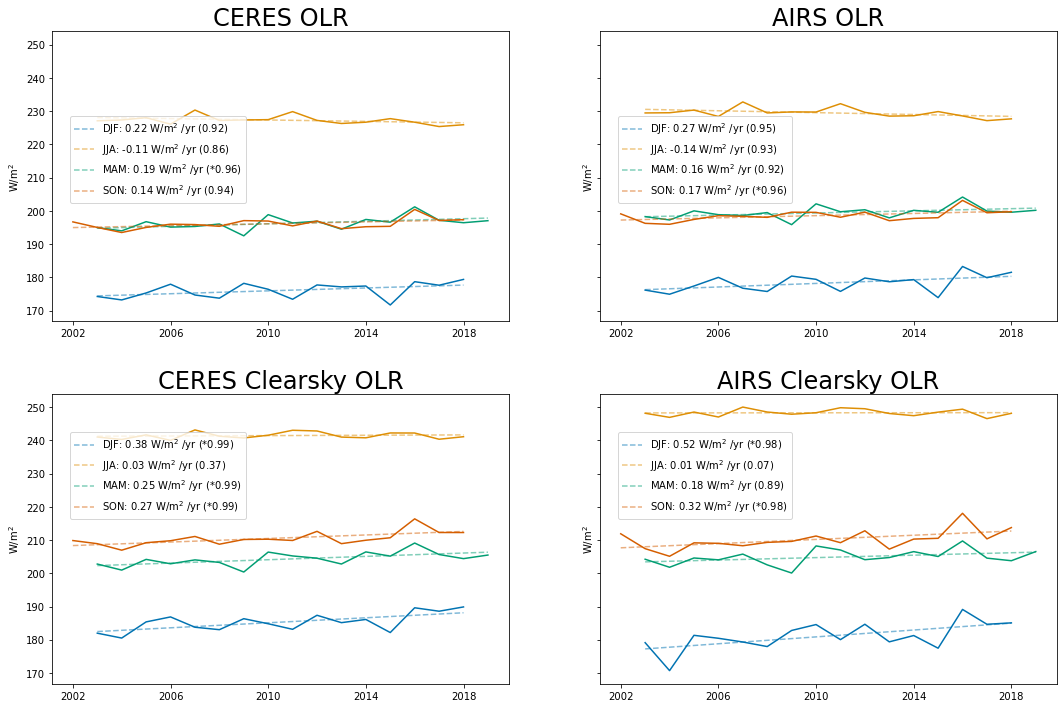

In [40]:
ceres_subtime = ceres_ds['toa_lw_all_mon'].sel(time=slice('2002-09','2019-06'))
ceres_subtime2 = ceres_ds['toa_lw_clr_c_mon'].sel(time=slice('2002-09','2019-06'))

fig,axs = plt.subplots(2,2,figsize=(18,12),sharey=True)

plt.subplots_adjust(hspace=0.25)

axs = axs.flat

# plot_trends(ceres_ds['toa_lw_all_mon'],'CERES OLR',seasonal=True,axes=axs[0],b_kwargs={'loc':(0.07,0.65)})
plot_trends(ceres_subtime,'CERES OLR',seasonal=True,axes=axs[0],units='W/m$^2$',b_kwargs={'loc':(0.04,0.41)})
plot_trends(ceres_subtime2,'CERES Clearsky OLR',seasonal=True,axes=axs[2],units='W/m$^2$',b_kwargs={'loc':(0.04,0.57)})

plot_trends(all_airs['olr'][:,0,:,:],'AIRS OLR',seasonal=True,axes=axs[1],units='W/m$^2$',b_kwargs={'loc':(0.04,0.41)})
plot_trends(all_airs['olr_clr'][:,0,:,:],'AIRS Clearsky OLR',seasonal=True,axes=axs[3],units='W/m$^2$',b_kwargs={'loc':(0.04,0.57)})

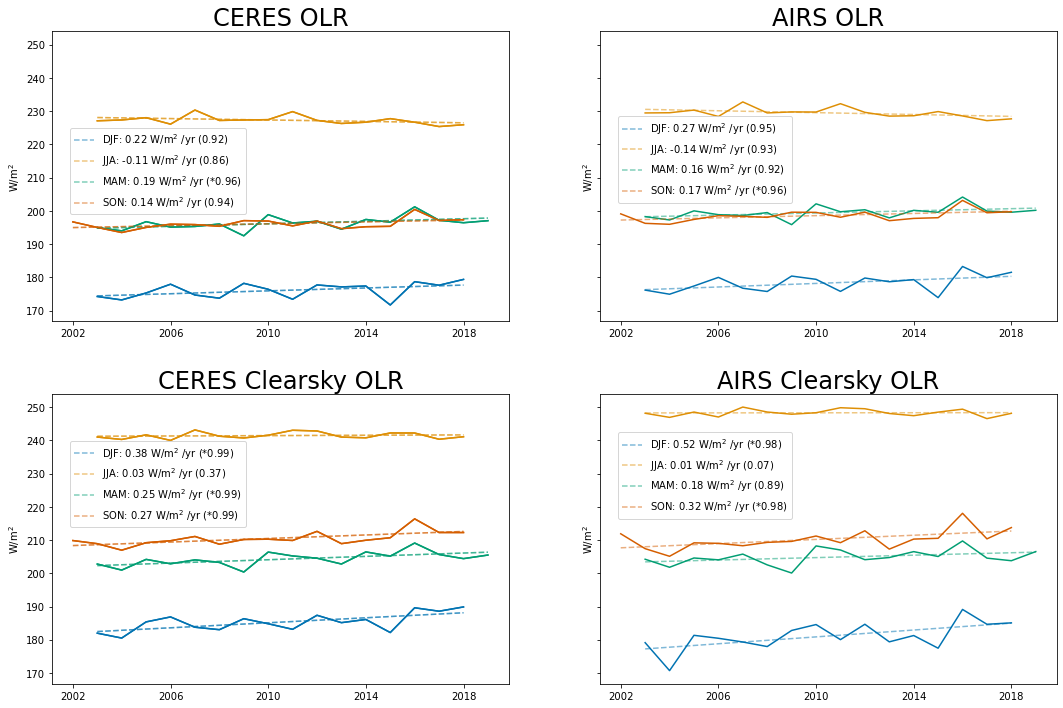

In [33]:
plot_trends(ceres_subtime,'CERES OLR',seasonal=True,axes=axs[0],units='W/m$^2$',b_kwargs={'loc':(0.04,0.37)})
plot_trends(ceres_subtime2,'CERES Clearsky OLR',seasonal=True,axes=axs[2],units='W/m$^2$',b_kwargs={'loc':(0.04,0.54)})

fig

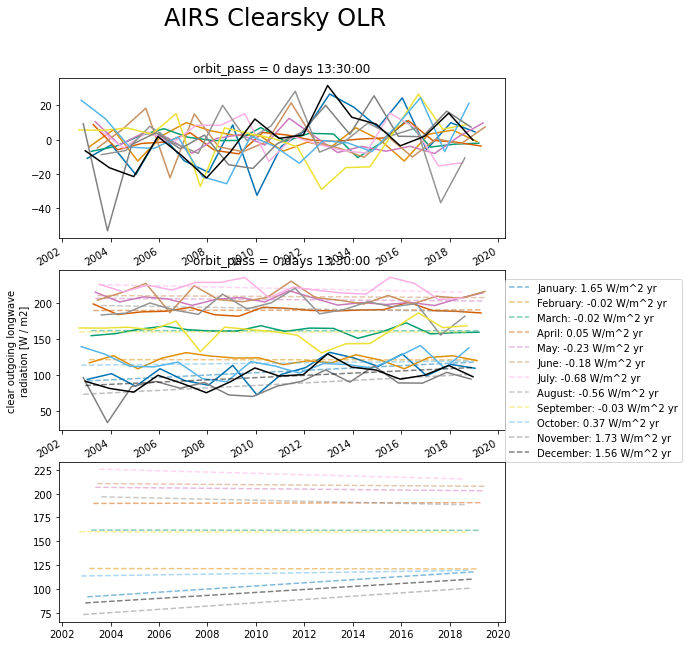

In [171]:
plot_trends(all_airs['olr_clr'][:,0,:,:],'AIRS Clearsky OLR')

## Calculate spectral trends

#### Average over the Arctic

In [29]:
all_airs['olr_clr_spectral']

,Array,Chunk
Bytes,5.21 GB,25.79 MB
Shape,"(202, 2, 199, 90, 180)","(1, 2, 199, 90, 180)"
Count,606 Tasks,202 Chunks
Type,float32,numpy.ndarray


In [3]:
spec_olr_save_file = '%s/arc_proc/spec_OLR_arcavg.nc' % airs_dir
spec_clrolr_save_file = '%s/arc_proc/spec_OLRCLR_arcavg.nc' % airs_dir

In [35]:
# Average spatially, leaving the time, wavelength, and overpass dimensions
# olr_spec_wgt = add_weights(all_airs['olr_spectral']) # arbitrarily pick the first satellite passover

# olr_spec_avg = masked_average(olr_spec_wgt,mask=olr_spec_wgt.lat<70,weights=olr_spec_wgt['cell_weight'],dim=['lat','lon'])

# olr_spec_avg.to_netcdf(specolr_save_file)

# olr_spec_wgt.close()

In [34]:
# Average spatially, leaving the time, wavelength, and overpass dimensions
# olrclr_spec_wgt = add_weights(all_airs['olr_clr_spectral']) # arbitrarily pick the first satellite passover

# olrclr_spec_avg = masked_average(olrclr_spec_wgt,mask=olrclr_spec_wgt.lat<70,weights=olrclr_spec_wgt['cell_weight'],dim=['lat','lon'])

# olrclr_spec_avg.to_netcdf(spec_clrolr_save_file)

# olrclr_spec_wgt.close()

In [44]:
# olr_spec_avg.rename({'__xarray_dataarray_variable__':'olr_spectral'}).to_netcdf(spec_olr_save_file)
# olrclr_spec_avg.rename({'__xarray_dataarray_variable__':'olr_clr_spectral'}).to_netcdf(spec_clrolr_save_file)

#### Open the processed files

In [4]:
olr_spec_avg = xr.open_dataarray(spec_olr_save_file)
olrclr_spec_avg = xr.open_dataarray(spec_clrolr_save_file)

In [5]:
# transpose for easier vectorization
olr_arc = olr_spec_avg.transpose('wnum','time',...)
olrclr_arc = olrclr_spec_avg.transpose('wnum','time',...)

#### Sanity plots

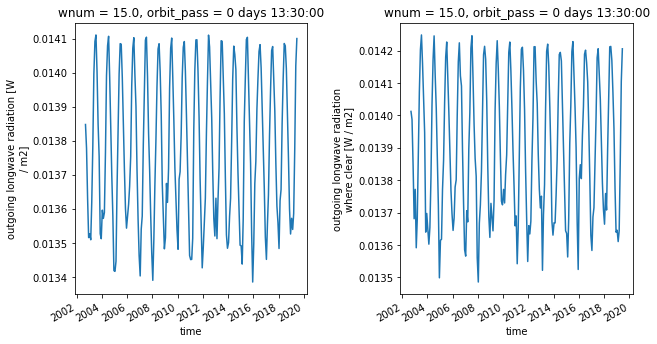

In [6]:
fig,axes = plt.subplots(1,2,figsize=(10,5))
plt.subplots_adjust(wspace=0.4)

olr_arc[0,:,0].plot(ax=axes[0])

olrclr_arc[0,:,0].plot(ax=axes[1])

In [9]:
olr_arc

<xarray.DataArray 'olr_spectral' (wnum: 199, time: 202, orbit_pass: 2)>
array([[[0.01384772, 0.0138465 ],
        [0.01377817, 0.01377117],
        [0.01363012, 0.0136241 ],
        ...,
        [0.01377638, 0.01375829],
        [0.01402032, 0.01402057],
        [0.01410009, 0.01410314]],

       [[0.03674969, 0.03674703],
        [0.03659692, 0.03655952],
        [0.03622172, 0.03620522],
        ...,
        [0.03662576, 0.03659455],
        [0.03719291, 0.03720521],
        [0.0373692 , 0.0373811 ]],

       [[0.06599387, 0.06597688],
        [0.06515211, 0.06511179],
        [0.06408735, 0.06406961],
        ...,
...
        ...,
        [0.03888542, 0.03465237],
        [0.05262883, 0.04879448],
        [0.06324045, 0.05932119]],

       [[0.04513979, 0.04350487],
        [0.03812935, 0.03759348],
        [0.03078062, 0.03032472],
        ...,
        [0.03570314, 0.03225542],
        [0.04752416, 0.04453627],
        [0.05574343, 0.05284035]],

       [[0.03789479, 0.03688569],
        [0.03321058, 0.03287086],
        [0.02794078, 0.02761102],
        ...,
        [0.03161252, 0.02947792],
        [0.04048832, 0.03875551],
        [0.04582763, 0.0442582 ]]], dtype=float32)
Coordinates:
  * wnum        (wnum) float32 15.0 25.0 35.0 45.0 ... 1975.0 1985.0 1995.0
  * orbit_pass  (orbit_pass) timedelta64[ns] 13:30:00 01:30:00
  * time        (time) datetime64[ns] 2002-09-15T12:00:00 ... 2019-06-15T12:0...
Attributes:
    units:                  W / m2
    ancillary_variables:    olr_spectral_nobs
    valid_range:            [1.e-03 2.e+03]
    long_name:              outgoing longwave radiation
    standard_name:          toa_outgoing_longwave_flux
    description:            All-sky outgoing longwave radiation flux per 10 cm-1
    cell_methods:           area: mean
    coverage_content_type:  physicalMeasurement

### Tweak trend function

In [38]:
# For making month labels
mon_dict = {'1':'January','2':'February','3':'March','4':'April','5':'May','6':'June',
           '7':'July','8':'August','9':'September','10':'October','11':'November','12':'December',
           }

def plot_trends2(ds,title):
    '''
    Create trend plot for preaveraged data.
    
    '''
    
#     var_wgt = add_weights(ds)
    # average over the Arctic Ocean spatially, but not temporally
#     spat_avg = masked_average(var_wgt,weights=var_wgt['cell_weight'],mask=var_wgt.lat<70,dim=['lat','lon'])
    
    fig,axes = plt.subplots(3,1,figsize=(8,10))

    lines=[]
    mon_groups = ds.groupby('time.month')

    for color,(ind,mon) in zip(sns.color_palette("colorblind")+['grey','black'],mon_groups):
        mon_norm = mon - mon.mean() # normalize to the average

        out = regress_1d(mon['time.year'],mon)
        line = (mon['time.year'].values*out.coef_ + out.intercept_).squeeze()
        label = '%s: %.2f W/m^2 yr' % (mon_dict[str(ind)],out.coef_)


        mon_norm.plot(label=label,ax=axes[0],color=color)
        out = mon.plot(label=label,ax=axes[1],color=color)

        axes[1].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)
        axes[2].plot(mon['time'],line,alpha=0.5,linestyle='dashed',label=label,color=color)

        lines.append(out)

    axes[2].legend(loc=[1,1])

    fig.suptitle(title,fontsize=24)
    

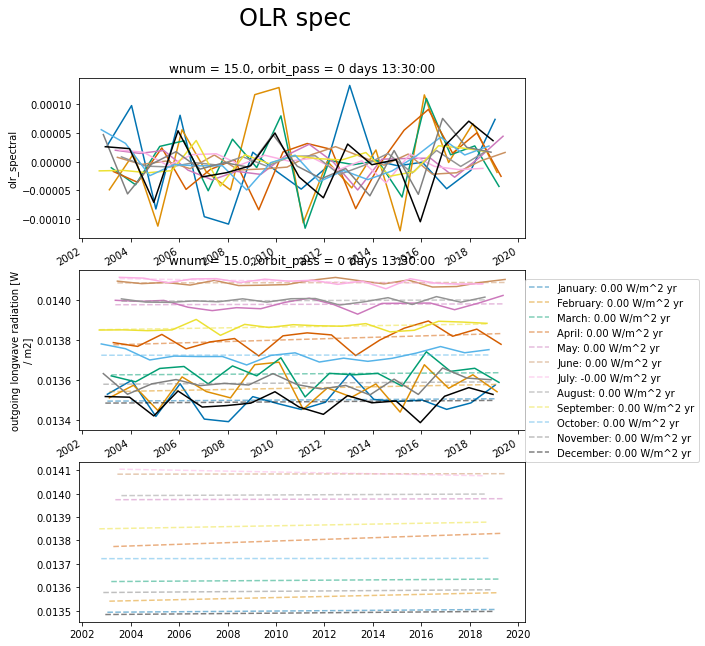

In [39]:
plot_trends2(olr_arc[0,:,0],'OLR spec')

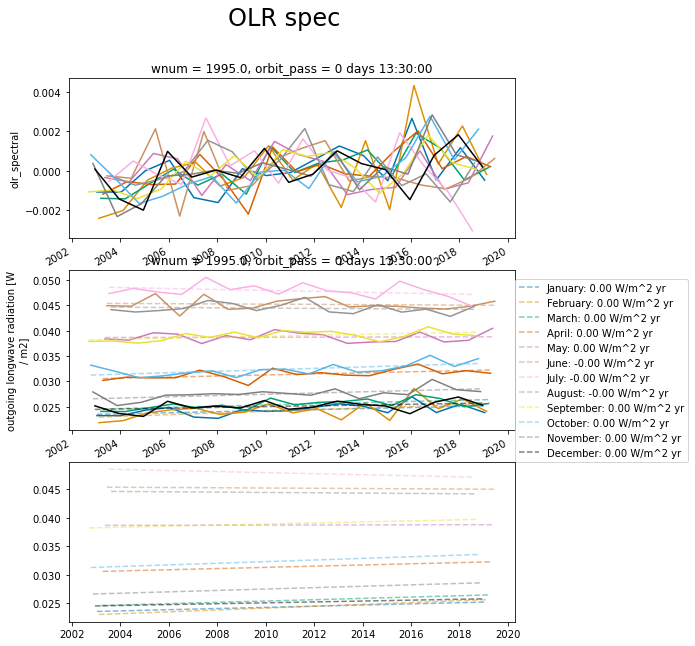

In [62]:
plot_trends2(olr_arc[198,:,0],'OLR spec')

### Develop trend functions

In [46]:
def calc_trends(ts):
    '''
    Calculate trends of spectral preaveraged AIRS data.
    Should work for vectorization.
    
    ts: TimeSeries (i.e. shape is just (len(time)))
    '''
    
    
    monthly = ts.groupby('time.month')
    
    outs = []
    for i,mon in monthly: # don't like this
    
        out = regress_1d(mon['time.year'],mon)
        outs.append(out.coef_)
    
    return np.array(outs).squeeze()

#### Loop over OLR and output an np.array

In [48]:
# don't need to vectorize I guess (only 199 loops)
%time

test_out = []

for w in olr_arc[:,:,0]:
    test_out.append(calc_trends(w))
    
olr_trends = np.array(test_out)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs


#### Repeat for clear-sky OLR

In [49]:
# don't need to vectorize I guess (only 199 loops)
%time

test_out = []

for w in olrclr_arc[:,:,0]:
    test_out.append(calc_trends(w))
    
olrclr_trends = np.array(test_out)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [170]:
gridtest = xr.DataArray(data=test_out,
                   dims=['wnum','month'],
                   coords=dict(
                       wnum=(olr_arc.wnum),
                       month=(list(mon_dict.values())),
                   ),
                   attrs=dict(
                       description="HDF to xarray test for AIRS level 1B",
                       doop='doop',
                   ),
                )

### Nice plot for OLR

NameError: name 'olr_trends' is not defined

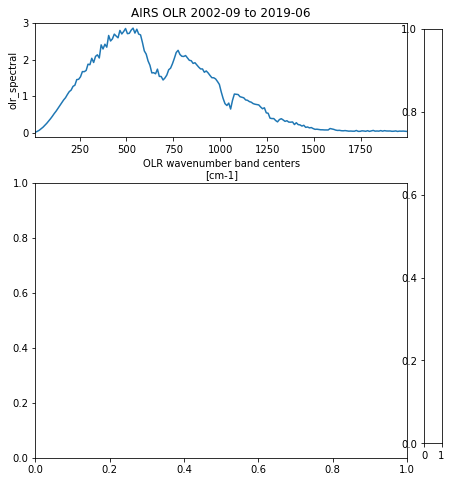

In [7]:
nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olr_arc.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

fig1 = plt.figure(constrained_layout=False,figsize=(12,8))
gs1 = fig1.add_gridspec(nrows=3, ncols=5, left=0.05, right=0.48, wspace=0.05,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:1, :])
f1_ax2 = fig1.add_subplot(gs1[-2:, :])

# Plot the average OLR
olr_arc[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
f1_ax1.set_title('AIRS OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olr_trends.transpose(), center=0, cmap='vlag', 
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax2,cbar_ax = cbar_axh2)

cbar = im.collections[0].colorbar
cbar.set_label('OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)')#, rotation=270)

f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))
f1_ax1b.set_xlabel('Wavelength ($\mu m$)') # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('OLR (W/m$^{2}$/10cm$^{-1}$)')
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)')

### Nice plot for CLR OLR

In [ ]:
nuthin = 199*[None]

# Only take every 15th wnum label (there must be a better way)
new_labels = [olrclr_arc.wnum[i].values if i%15 == 0 else b for  i,b in enumerate(nuthin)]

fig1 = plt.figure(constrained_layout=False,figsize=(12,8))
gs1 = fig1.add_gridspec(nrows=3, ncols=5, left=0.05, right=0.48, wspace=0.05,hspace=0.4)
f1_ax1 = fig1.add_subplot(gs1[:1, :])
f1_ax2 = fig1.add_subplot(gs1[-2:, :])

# Plot the average OLR
olrclr_arc[:,:,0].groupby('time.month').mean('time').mean('month').plot(ax=f1_ax1,xlim=[15,1995])
f1_ax1.set_title('AIRS Clearsky OLR 2002-09 to 2019-06')# (Wm$^{-2}$)')
# fig1.suptitle('AIRS OLR 2002-09 to 2019-06 (Wm$^{-2}$)')

cbar_axh2 = fig1.add_axes([0.5, 0.15, 0.02, 0.72])

im = sns.heatmap(olrclr_trends.transpose(), center=0, cmap='vlag', 
            xticklabels=new_labels,yticklabels=mon_dict.values(),
           ax=f1_ax2,cbar_ax = cbar_axh2)

cbar = im.collections[0].colorbar
cbar.set_label('Clearsky OLR trend (W/m$^{2}$/10cm$^{-1}$/yr)')#, rotation=270)

f1_ax2.set_xlabel('Wavenumber (cm$^{-1}$)')

f1_ax1b = f1_ax1.twiny()

ax1Ticks = f1_ax1.get_xticks()   
ax2Ticks = ax1Ticks

def tick_function(X):
    V = 1e4/X
    return ["%.1f" % z for z in V]

f1_ax1b.set_xticks(ax2Ticks)
f1_ax1b.set_xbound(f1_ax1.get_xbound())
f1_ax1b.set_xticklabels(tick_function(ax2Ticks))
f1_ax1b.set_xlabel('Wavelength ($\mu m$)') # W/m$^{2}$/10cm$^{-1}$
f1_ax1.set_ylabel('Clearsky OLR (W/m$^{2}$/10cm$^{-1}$)')
f1_ax1.set_xlabel('Wavenumber (cm$^{-1}$)')

Text(0.5, 371.4378947368421, 'Wavenumber (cm$^{-1}$)')

CO2 and O3 lines

In [110]:
%time
test = calc_trends(olr_arc[0,:,0])

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 5.01 µs


In [111]:
test

array([ 7.36977467e-07,  2.25637546e-06,  6.64455287e-07,  3.51976019e-06,
        2.72071738e-07,  1.30522120e-07, -1.86234384e-06,  4.44827053e-07,
        1.78646844e-06,  8.72498597e-08,  7.35886358e-07,  8.35366675e-07])

In [57]:
arc_ocn_avg = masked_average(month,weights=month['cell_weight'],mask=month.lat>70)

In [58]:
arc_ocn_avg

<xarray.DataArray ()>
array(239.40678, dtype=float32)
Attributes:
    long_name:      Top of The Atmosphere Longwave Flux, All-Sky conditions, ...
    standard_name:  TOA Longwave Flux - All-Sky
    CF_name:        toa_outgoing_longwave_flux
    comment:        none
    units:          W m-2
    valid_min:            0.00000
    valid_max:            400.000

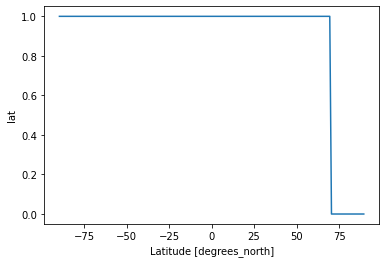

In [55]:
(month.lat<70).plot()

/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/glade/work/jonahshaw/miniconda3/envs/cheycomp/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


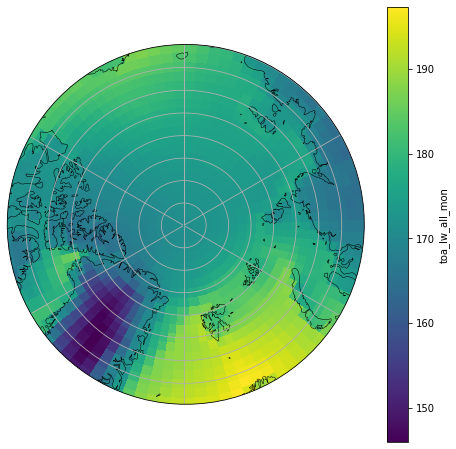

In [43]:
fig,ax = sp_map(nrows=1, ncols=1, projection=ccrs.NorthPolarStereo(), figsize=[8,8])

polarCentral_set_latlim([70,90], ax)

month.where(month.lat>70).mean('time').plot(ax=ax, transform=ccrs.PlateCarree())

add_map_features(ax)

In [21]:
type(group)

xarray.core.dataarray.DataArray

In [33]:
ax.plot(month.where(month.lat>70).mean('time'),projection=ccrs.NorthPolarStereo())

AttributeError: 'Line2D' object has no property 'projection'

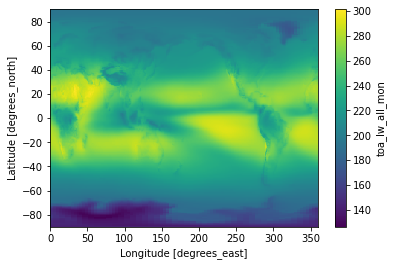

In [9]:
ceres_ds['toa_lw_all_mon'].mean('time').plot()

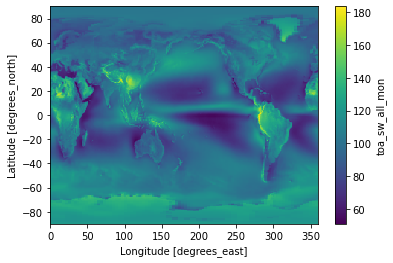

In [10]:
ceres_ds['toa_sw_all_mon'].mean('time').plot()

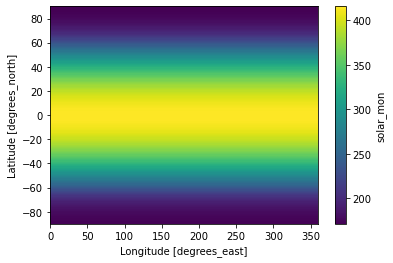

In [11]:
ceres_ds['solar_mon'].mean('time').plot()

In [ ]:
OSR=ds.toa_sw_all_mon.mean('time') ### outgoing solar radiation, measured by CERES
SOLIN=ds.solar_mon.mean('time')    ### incoming solar radiation, from the sun
ASR=SOLIN-OSR  ### sign convention, positive down.  incoming solar radiation minus outgoing solar radiation